In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 400
df = pd.read_csv("output/result.csv", header=None)
columns = [
              'thread',
              'problem',
              'query',
              'explanation',
              'status',
              'test accuracy',
              'rnn score',
              'LTL explanation score',
              'explanation score on ground truth',
              'LTL extraction time',
              'revised delta',
              'revised epsilon',
              'counterexamples',
              'train size',
              'test size',
              'LTL depth',
            'lstar states',
            'lstar explanation score',
            'lstar explanation score on ground truth',
            'lstar extraction time',
            'lstar status', 
            'epsilon', 
            'delta'
            ,
            'learner time', 
            'verifier time', 
            'random words'
            ]
if(len(df.columns) < len(columns)):
  df.columns = columns[:-3]
else:
  df.columns = columns


# remove two queries from balanced parentheses
df = df[~((df['problem']=='balanced parentheses') & ((df['query']=='G(l -> F(a | r))') | (df['query']=='G(l -> ~(F(a | r)))')))]


# df = df[(df['thread'] <=5 )]
# df = df[(df['lstar extraction time']!=0) & (df['epsilon'] == 0.05) & (df['delta'] == 0.05) ]
markersize = 20
fontsize = 32
labelsize = 20



med = df.groupby(['problem','query','epsilon','delta'], as_index=False).mean()[['problem','query','LTL explanation score','lstar explanation score','LTL depth','lstar states', 'LTL extraction time','lstar extraction time','revised epsilon','revised delta','rnn score']]

# med = df[['problem','query','LTL explanation score','lstar explanation score','LTL depth','lstar states', 'LTL extraction time','lstar extraction time','revised epsilon','revised delta','rnn score']]


med['summary explainability'] = med.apply(lambda x : "win" if x['LTL depth'] < x['lstar states'] else ("tie" if x['LTL depth'] == x['lstar states'] else "lose"), axis=1)
med['summary accuracy'] = med.apply(lambda x : "win" if x['LTL explanation score'] > x['lstar explanation score'] else ("tie" if x['LTL explanation score'] == x['lstar explanation score'] else "lose"), axis=1)

med.to_csv("output/average.csv", index=False)

print("minimum iterations:", min(df.groupby(['problem','query'])['status'].count()), "max iterations:",max(df.groupby(['problem','query'])['status'].count()))


minimum iterations: 7 max iterations: 700


In [2]:
import os
os.system("mkdir output/csv")

dic={"F(x0)":"F-a",
     "G(->(x0,X(x1)))":"G-a-X-b",
     "alternating bit protocol":"abp",
     "balanced parentheses": "bp",
     "email match":"email",
     'Text classification': "spam",
     "F(&(x0,X(x1)))":"F-a-x-b",
     'G(x0)':"G-a"}
for key, item in med.groupby(['problem'], as_index=False):
    item.reset_index(inplace=True)
    item.index += 1
    item.index.names = ['query-no']
    item = item[['LTL explanation score','lstar explanation score','LTL depth','lstar states','LTL extraction time','lstar extraction time']]
    item.columns=["accuracy-LTL",	"accuracy-DFA",	"size-LTL",	"size-DFA",	"time-LTL",	"time-DFA"]
    item.to_csv("output/csv/"+dic[key]+".csv")

    

In [3]:
from lexr.specific_examples import *
tc = Text_Classification()
tc_dic = tc.tok.index_word

In [4]:
from samples2ltl.utils.SimpleTree import Formula
import re

# for extracting representative rules
replace_dict = dict(zip([
            #    "d",
            "X",
            '|',
            "U",
            "F",
            "G",
            "&",
            "~",
            "!",
            "->",
            "true",
            "false",
        ], [

            #    "\\\\circ",
            "\\X ",
            "\\vee ",
            "\\U ",
            "\\F ",
            "\\G ",
            " \\wedge ",
            " \\neg ",
            " \\neg ",
            " \\rightarrow",
            "\\top",
            "\\bot",
        ]))

replace_dict_email = dict(zip([
    "X",
    '|',
    "U",
    "F",
    "G",
    "d",
    "&",
    "~",
    "!",
    "false",
    "a",
    "->",
    "true",
], [
    "\\X ",
    "\\vee ",
    "\\U ",
    "\\F ",
    "\\G ",
    "\\circ ",
    " \\wedge ",
    " \\neg ",
    " \\neg ",
    "\\bot",
    "@",
    " \\rightarrow",
    "\\top",
]))

replace_dict_balanced = dict(zip([
    #    "d",
    "X",
    '|',
    "U",
    "F",
    "G",
    "&",
    "~",
    "!",
    "->",
    "true",
    "false",
    #    "a"
], [

    #    "\\\\circ",
    "\\X ",
    "\\vee ",
    "\\U ",
    "\\F",
    "\\G",
    " \\wedge ",
    " \\neg ",
    " \\neg ",
    " \\rightarrow",
    "\\top",
    "\\bot",
    #    "@"
]))

replace_dict_bit = dict(zip([
    #    "d",
    "b",
    "X",
    '|',
    "U",
    "F",
    "G",
    "~",
    '!',
    "true",
    "false",
    "a",
    "->",
    "c",
    "d",
    "&",

], [

    #    "\\\\circ",
    "\\text{msg}1",
    "\\X ",
    "\\vee ",
    "\\U ",
    "\\F ",
    "\\G ",
    " \\neg ",
    " \\neg ",
    "\\top",
    "\\bot",
    "\\text{msg}0",
    " \\rightarrow",
    "\\text{ack}0",
    "\\text{ack}1",
    " \\wedge ",

    #    "@"
]))



variable_definition = {
    "email match" : {
        "x0" : "a",
        "x1" : "d",
        "x2" : "m",
        "x3" : "p"
    },
    "balanced parentheses" : {
        "x0" : "l",
        "x1" : "r",
        "x2" : "a"
    },
    "F(x0)" : {
        "x0" : "a",
        "x1" : "b",
        "x2" : "c"
    },
     "G(->(x0,X(x1)))" : {
        "x0" : "a",
        "x1" : "b",
        "x2" : "c"
    },
     "alternating bit protocol": {
        "x0" : "\\text{bit}0",
        "x1" : "\\text{bit}1",
        "x2" : "\\text{ack}0",
        "x3" : "\\text{ack}1"
     },
     "F(&(x0,X(x1)))" : {
        "x0" : "a",
        "x1" : "b",
        "x2" : "c"
    },
     '\G (x0)': {
        "x0" : "a",
        "x1" : "b",
        "x2" : "c"
    }, 
    'Text classification': tc_dic
}




In [5]:
rules_df = df
# rules_df.groupby(['problem','query'], as_index = False)['explanation'].mode()


problems = rules_df['problem'].unique()
cnt = 0

s = ""

for problem_ in problems:

    
    
    

    print_once = True
    index = 1
    for key, item in rules_df.groupby(['problem','query'], as_index=False):
        problem, query = key
        if(problem_ != problem):
            continue
        
        problem_str=''
        if(problem == "email match"):
            problem_str = "Email"
            # print("  ", "Email", "  ")
        elif(problem == "balanced parentheses"):
            # print("  ", "BP", "  ")
            problem_str = "BP"
        elif(problem == "alternating bit protocol"):
            # print("  ", "Bit", "  ")
            problem_str = "Bit"
        elif(problem == "Text classification"):
            problem_str = "Spam"
        else:
            problem_str = Formula.convertTextToFormula(problem).prettyPrint()
            for key in replace_dict.keys():
                problem_str = problem_str.replace(key, replace_dict[key])
            _dic = {"x0" : "a", "x1" : "b", "x2" : "c", "x3" : "d"}
            for key in _dic:
                problem_str = problem_str.replace(key, _dic[key])
            problem_str =" $ " + problem_str + " $ "
            # print(" $ ", problem, " $ ")
        
        if(print_once):
            
            s += """  
\\begin{longtable}{p{1.5cm}rp{4 cm}p{5 cm}r}
%\\caption{Example of LTL explanations of the RNN on\n"""
            s += "%" + problem_str + "\n"
            s += "%"".}""\n"
            s += "%\\label{tab:example"+str(cnt)+"}\n"
            s += """
            
            %\\begin{center}
                %\\begin{tabular}{p{1.5cm}rp{5 cm}p{5 cm}r}
                    \\toprule
                    Problem & No. & Query & Explanation & Acc\\\\
                    \\midrule \n
            """
            # print(problem)
            s += "  " + problem_str + "  \n"

            print_once = False
        # explanation = item['explanation'].mode()[0] # most frequent
        item.reset_index(inplace=True, drop=True)
        explanation = item.iloc[item.index[(item['LTL explanation score']-med['LTL explanation score'][(med['problem']==problem_) & (med['query'] == query)].item()).abs().argsort()][0]]['explanation']
        
        explanation_score = med[(med['problem']==problem_) & (med['query'] == query)]['LTL explanation score'].round(1).item()
        ltl_depth = med[(med['problem']==problem_) & (med['query'] == query)]['LTL depth'].round(1).item()
        extraction_time = med[(med['problem']==problem_) & (med['query'] == query)]['LTL extraction time'].round(2).item()
        if(extraction_time > 400):
            extraction_time = "\\text{\\textemdash}"
        explanation =  explanation[1:-1] if (explanation[0]=="(" and explanation[-1] == ")") else explanation
        lstar_time = med[(med['problem']==problem_) & (med['query'] == query)]['lstar extraction time'].round(2).item()
        lstar_states = med[(med['problem']==problem_) & (med['query'] == query)]['lstar states'].round(1).item()
        lstar_acc = med[(med['problem']==problem_) & (med['query'] == query)]['lstar explanation score'].round(1).item()

        query = Formula.convertTextToFormula(query).prettyPrint()

        if(lstar_time > 400):
            lstar_time = "\\text{\\textemdash}"

        if(problem == "email match"):
            for key in replace_dict_email.keys():
        
                explanation = explanation.replace(key, replace_dict_email[key])
                query = query.replace(key, replace_dict_email[key])
        elif(problem == "balanced parentheses"):
            for key in replace_dict_balanced.keys():
        
                explanation = explanation.replace(key, replace_dict_balanced[key])
                query = query.replace(key, replace_dict_balanced[key])
        elif(problem == "alternating bit protocol"):
            for key in replace_dict_bit.keys():
        
                explanation = explanation.replace(key, replace_dict_bit[key])
                query = query.replace(key, replace_dict_bit[key])

        else:
            for key in replace_dict.keys():
                explanation = explanation.replace(key, replace_dict[key])
                query = query.replace(key, replace_dict[key])

        if(problem in variable_definition):
            if(problem != "Text classification"):
                for key in variable_definition[problem].keys():        
                        explanation = explanation.replace(key, variable_definition[problem][key])
                        query = query.replace(key, variable_definition[problem][key])
            else:
                indices = re.findall(r'\d+', query)
                for x in indices:
                    if(x != "0"):
                        query = query.replace("x" + x, "\\text{" + tc_dic[int(x)].encode('ascii', 'ignore').decode("utf-8") + "}")
                    else:
                        query = query.replace("x" + x, "\\text{Null}")
                

                indices = re.findall(r'\d+', explanation)
                for x in indices:
                    if(x != "0"):
                        explanation = explanation.replace("x" + x, "\\text{" + tc_dic[int(x)].encode('ascii', 'ignore').decode("utf-8") + "}")
                    else:
                        explanation = explanation.replace("x" + x, "\\text{Null}")
        else:
            print(problem)     
            
        
        s += '& $' + str(index) + "$ & $" + query + "$ & $" + explanation + "$ & $" + str(explanation_score) + "$ \\\\\n"
        # print(ltl_depth)
        # print('& $', query,"$ & $", explanation, "$ & $",ltl_depth, "$ & $", explanation_score, "$ & $", extraction_time, "$ & $", lstar_states, "$ & $", lstar_acc, "$ & $", lstar_time,  "$ \\\\")
        s +="\\addlinespace[1em]\n"
        
        index +=1
    # if(cnt < len(problems) - 1):
    #     print("\\midrule\n\n\n")
    cnt += 1

    s += """ 
                \\bottomrule
                %\\end{tabular}
            %\\end{center}\n"""

    s += "\\end{longtable} \n\n\n\n\n"

# print(s)

out_file = open("../paper/neurIPS-20/section/new_results.tex", 'w')
out_file.write(s)
out_file.close()



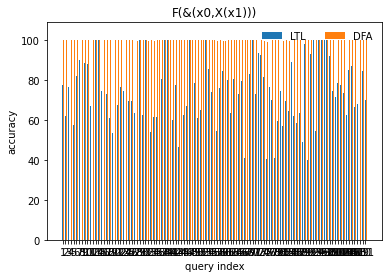

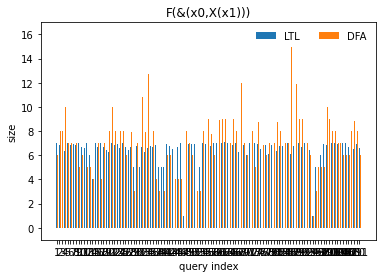

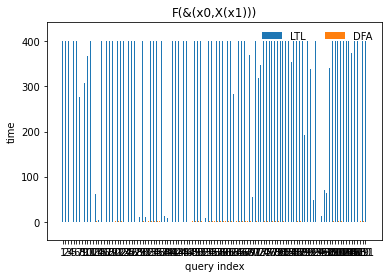

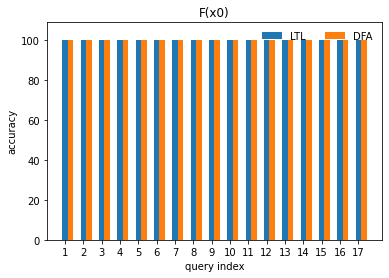

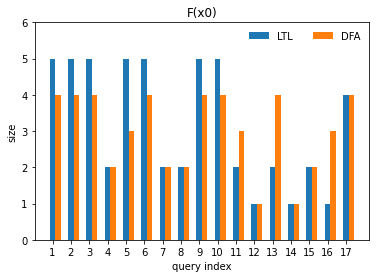

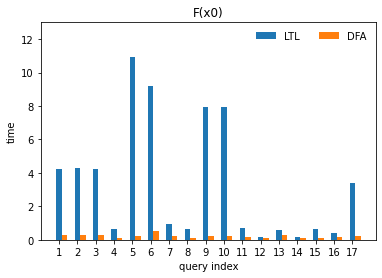

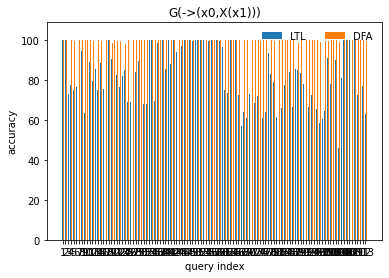

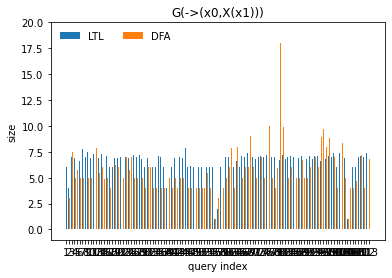

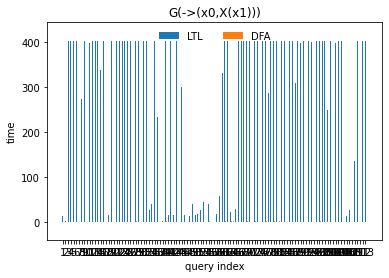

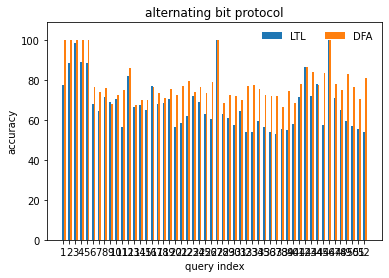

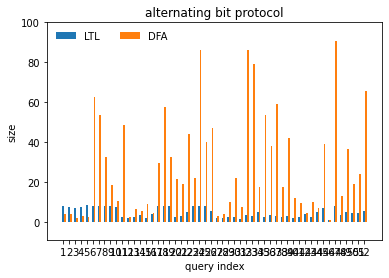

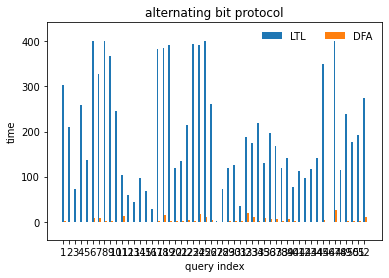

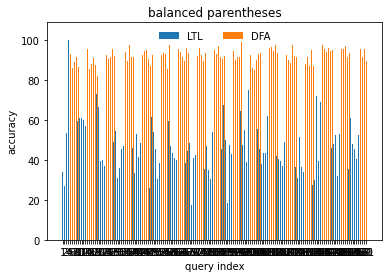

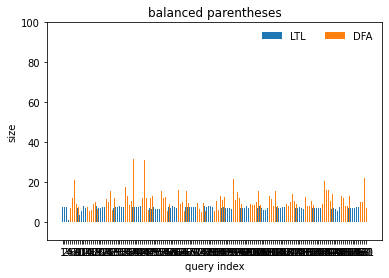

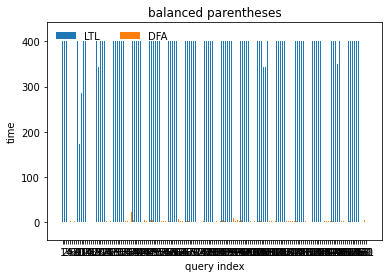

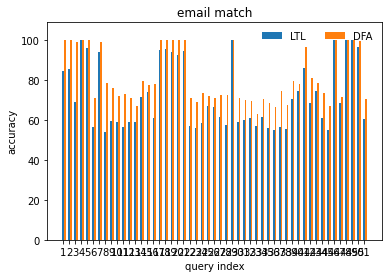

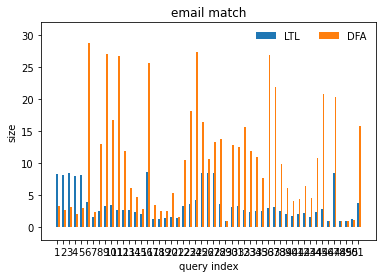

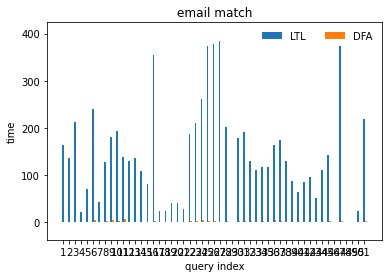

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import math
import os
os.system("mkdir output/fig")
problems = med['problem'].unique()
index = 0
for problem in problems:

    
    ax = plt.subplot(111)
    
    x1 = med[med['problem']==problem]['LTL explanation score'].to_list()
    x2 = med[med['problem']==problem]['lstar explanation score'].to_list()

    # print(problem)
    # print(med[med['problem']==problem][['query','LTL explanation score']])
    print("\n\n\n")

    pos = [i+1 for i in range(len(x1))]
    ax.bar(pos,x1,width=0.3,  align='center', label='LTL')
    ax.bar([i+0.3 for i in pos],x2,width=0.3,  align='center', label="DFA")
    ax.set_title(problem)
    ax.set_ylabel("accuracy")
    ax.set_xlabel("query index")
    ax.legend(loc='best',ncol=2, frameon=False)
    # low = min([min(x1),min(x2)])
    # high = max([max(x1),max(x2)])
    # ax.set_ylim([math.ceil(low-0.2*(high-low)), 109])
    ax.set_ylim([0,109])

    ax.set_xticks(pos)
    plt.savefig('output/fig/'+str(index)+'_accuracy_bar.pdf')
    plt.show()
    plt.clf()


    ax = plt.subplot(111)
    
    x1 = med[med['problem']==problem]['LTL depth'].to_list()
    x2 = med[med['problem']==problem]['lstar states'].to_list()
    
    pos = [i+1 for i in range(len(x1))]
    ax.bar(pos,x1,width=0.3,  align='center', label='LTL')
    ax.bar([i+0.3 for i in pos],x2,width=0.3,  align='center', label="DFA")
    ax.set_title(problem)
    ax.set_ylabel("size")
    ax.set_xlabel("query index")
    ax.legend(loc='best',ncol=2, frameon=False)
    low = min([min(x1),min(x2)])
    low = 0
    high = max([max(x1),max(x2)])
    ax.set_ylim([math.ceil(low-0.1*(high-low)), math.ceil(high+0.1*(high-low))])

    ax.set_xticks(pos)
    plt.savefig('output/fig/'+str(index)+'_size_bar.pdf')
    plt.show()
    plt.clf()

    ax = plt.subplot(111)
    
    x1 = med[med['problem']==problem]['LTL extraction time'].to_list()
    x2 = med[med['problem']==problem]['lstar extraction time'].to_list()
    
    pos = [i+1 for i in range(len(x1))]
    ax.bar(pos,x1,width=0.3,  align='center', label='LTL')
    ax.bar([i+0.3 for i in pos],x2,width=0.3,  align='center', label="DFA")
    ax.set_title(problem)
    ax.set_ylabel("time")
    ax.set_xlabel("query index")
    ax.legend(loc='best',ncol=2, frameon=False)
    low = min([min(x1),min(x2)])
    high = max([max(x1),max(x2)])
    ax.set_ylim([math.ceil(low-0.1*(high-low)), math.ceil(high+0.1*(high-low))])

    ax.set_xticks(pos)
    plt.savefig('output/fig/'+str(index)+'_time_bar.pdf')
    plt.show()
    plt.clf()




    index += 1
    




F(x0) 11


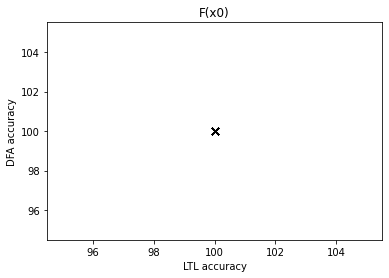

In [5]:

import os
os.system("mkdir output/fig")
replace_dict = dict(zip([
    "email match",
    "alternating bit protocol",
    'balanced parentheses',
    '&',
    "->",
    'true',
    'false',
    "\|",
    '~'
], [
    'Email',
    'Bit',
    'BP',
    r'$\\wedge$',
    r'$\\rightarrow$',
    r'$\\top$',
    r'$\\bot$',
    r'$\\vee$',
    r'$\\neg$'
]))
med['problem'] = med['problem'].replace(replace_dict, regex=True)
med['query'] = med['query'].replace(replace_dict, regex=True)



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm

# for colors
colors = ['b', 'c', 'y', 'm', 'r','g']

marker = ['x', 'o', "v", '*', 's', "p", 'D', '^']
# line = mlines.Line2D([0, 1], [0, 1], color='black')
# transform = ax.transAxes
# line.set_transform(transform)
# ax.add_line(line)
problems = med['problem'].unique()
index = 0
for problem in problems:
    cnt = 0
    fig, ax = plt.subplots()
    
    for key, item in med.groupby(['problem','query']):

        problem_, query = key
        if(problem == problem_):
            try:
                x = item['LTL explanation score']
                y = item['lstar explanation score']
                ax.scatter(x,y,marker='x', c='black',s=50,label=problem +", "+query)  

     
            except:
                break
            cnt += 1
    print(problem, cnt)
    ax.set_title(problem)
    ax.ticklabel_format(useOffset=False)
    ax.set_xlabel("LTL accuracy")
    ax.set_ylabel("DFA accuracy")
    plt.savefig('output/fig/'+str(index)+'_accuracy_scatter.pdf')
    index += 1

    



F(x0) 11


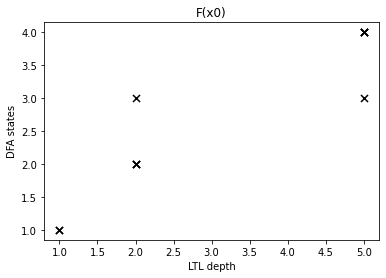

In [6]:


index = 0 
for problem in problems:
    
    cnt = 0
    fig, ax = plt.subplots()
    for key, item in med.groupby(['problem','query']):

        problem_, query = key
        if(problem == problem_):
            try:
                x = item['LTL depth']
                y = item['lstar states']
                ax.scatter(x,y,marker='x', c='black',s=50,label=problem +", "+query)       
                
                
            except:
                break
            cnt += 1
    print(problem, cnt)

    ax.set_title(problem)
    # ax.set_ylim([max(int(min(y))-5,0), int(min(y))+10 + max(int(math.ceil(max(y)))-int(min(y))+2,5)])
    # ax.set_xlim([int(min(x))-1, int(min(x))+max(int(math.ceil(max(x)))-int(min(x))+2,5)])
    ax.set_xlabel("LTL depth")
    ax.set_ylabel("DFA states")
    # plt.legend(loc='best',frameon=True)
    # plt.show()
    plt.savefig('output/fig/'+str(index)+'_explainability_scatter.pdf')
    index += 1

In [7]:
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 400
df = pd.read_csv("output/result.csv", header=None)
columns = ['thread',
              'problem',
              'query',
              'explanation',
              'status',
              'test accuracy',
              'rnn score',
              'LTL explanation score',
              'explanation score on ground truth',
              'LTL extraction time',
              'revised delta',
              'revised epsilon',
              'counterexamples',
              'train size',
              'test size',
              'LTL depth',
            'lstar states',
            'lstar explanation score',
            'lstar explanation score on ground truth',
            'lstar extraction time',
            'lstar status', 
            'epsilon', 
            'delta'
            ,
            'learner time', 
                                          'verifier time', 
            'random words'
              ]
if(len(df.columns) < len(columns)):
  df.columns = columns[:-3]
else:
  df.columns = columns


markersize = 20
fontsize = 32
labelsize = 20





In [8]:
replace_dict = dict(zip([
            #    "d",
            "X",
            '|',
            "U",
            "F",
            "G",
            "&",
            "~",
            "->",
            "true",
            "false",
        ], [

            #    "\\\\circ",
            "_X_",
            "_vee_",
            "_U_",
            "_F_",
            "_G_",
            "_wedge_",
            "_neg_",
            "_rightarrow_",
            "_top_",
            "_bot_",
        ]))
med = df.groupby(['problem','query','epsilon','delta'], as_index=False).mean()[['problem','query','epsilon','delta','LTL explanation score','lstar explanation score','LTL depth','lstar states', 'LTL extraction time','lstar extraction time','revised epsilon','revised delta','rnn score']]
import os 
os.system("mkdir output/fig")

med
   

,problem,query,epsilon,delta,LTL explanation score,lstar explanation score,LTL depth,lstar states,LTL extraction time,lstar extraction time,revised epsilon,revised delta,rnn score
0,F(x0),F(!(x0)),0.05,0.05,100.0,100.0,5,4,2.007963,0.147983,NaN,NaN,100.0
1,F(x0),F(!(x1)),0.05,0.05,100.0,100.0,2,2,0.389549,0.056319,NaN,NaN,100.0
2,F(x0),"F(&(x0,X(x1)))",0.05,0.05,100.0,100.0,5,3,13.815014,0.146358,NaN,NaN,100.0
3,F(x0),"F(U(x0,x1))",0.05,0.05,100.0,100.0,5,4,4.259638,0.276599,NaN,NaN,100.0
4,F(x0),"F(U(x1,x0))",0.05,0.05,100.0,100.0,2,2,0.567162,0.119680,NaN,NaN,100.0
5,F(x0),F(x1),0.05,0.05,100.0,100.0,5,4,4.699632,0.146678,NaN,NaN,100.0
6,F(x0),F(x2),0.05,0.05,100.0,100.0,5,4,6.025681,0.150586,NaN,NaN,100.0
7,F(x0),G(x0),0.05,0.05,100.0,100.0,2,3,0.432084,0.089223,NaN,NaN,100.0
8,F(x0),G(x2),0.05,0.05,100.0,100.0,1,1,0.106620,0.053937,NaN,NaN,100.0
9,F(x0),false,0.05,0.05,100.0,100.0,1,1,0.101596,0.054627,NaN,NaN,100.0


In [9]:
import matplotlib.pyplot as plt

plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

targets = ["F(a)"]
query_ = "true"
fixed_param_values = [0.05, 0.1, 0.25, 0.5]

width = 0.5

show = True


for target in targets:
    for fixed_param_value in fixed_param_values:

        extracted_df=med[(med['problem']==target)]
        

        grouplist=['problem','query','delta']
        for key, item in extracted_df.groupby(grouplist):
            _,query,delta=key
            if(delta != fixed_param_value or query != query_):
                continue
            
            print("\n\n\n")
            print(key)
            
            x_ = 'epsilon'
            
            item = item.sort_values(x_, ascending = True)
            # print(item[[ 'LTL explanation','LTL extraction time', 'LTL explanation score', 'epsilon', 'delta']].to_string(index=False))
            
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.bar([i for i in range(len(item[x_].tolist()))],item['LTL extraction time'], width)
            plt.xticks([i for i in range(len(item[x_].tolist()))],item[x_])
            plt.tick_params(labelsize=labelsize)
            plt.ylabel("time (s)", fontsize=fontsize)
            plt.xlabel(r"$"+"\\"+x_+"$", fontsize=fontsize)
            plt.tight_layout()

            if(query==query_):
                target_name=target
                query_name=query
                for key in replace_dict.keys():
                     target_name= target_name.replace(key, replace_dict[key])
                     query_name= query_name.replace(key, replace_dict[key])
                     
                plt.savefig("output/fig/"+target_name.replace(" ", "_")+"_"+query_name+"_"+x_+"_"+str(int(fixed_param_value*100))+"_time.pdf",bbox_inches='tight')
            if(show):
                plt.show()
            plt.clf()

        grouplist=['problem','query','epsilon']


for target in targets:
    for fixed_param_value in fixed_param_values:

        extracted_df=med[(med['problem']==target)]

        for key, item in extracted_df.groupby(grouplist):
            _,query,epsilon=key
            if(epsilon != fixed_param_value or query != query_):
                continue
            
            print("\n\n\n")
            print(key)

            x_ = 'delta'
            
            item = item.sort_values(x_, ascending = True)
            # print(item[[ 'LTL explanation','LTL extraction time', 'LTL explanation score', 'epsilon', 'delta']].to_string(index=False))
            
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.bar([i for i in range(len(item[x_].tolist()))],item['LTL extraction time'], width)
            plt.xticks([i for i in range(len(item[x_].tolist()))],item[x_])
            plt.tick_params(labelsize=labelsize)
            plt.ylabel("time (s)", fontsize=fontsize)
            plt.xlabel(r"$"+"\\"+x_+"$", fontsize=fontsize)
            plt.tight_layout()
            if(query==query_):
                target_name=target
                query_name=query
                for key in replace_dict.keys():
                     target_name= target_name.replace(key, replace_dict[key])
                     query_name= query_name.replace(key, replace_dict[key])
                     
                plt.savefig("output/fig/"+target_name.replace(" ", "_")+"_"+query_name+"_"+x_+"_"+str(int(fixed_param_value*100))+"_time.pdf",bbox_inches='tight')
            if(show):
                plt.show()
    
            plt.clf()


